# Australian Ocean Surface Wave Measurements from SAR

Authors: Salman Khan and Emilio Echevarria

### Table of contents:
- About Sentinel-1  Ocean Surface Wave Measurements
- Required Python packages and utility functions
- Read a daily along-track netCDF file and visualise selected measurements off Albany, WA on a map
- Plot some auxialliary variables as the satellite measures along-track
- Convert directional wavenumber spectra to frequency spectra using deep water assumptions
- Plot some wave statistics derived from directional frequency spectra
- Visualise directional frequency spectra: (i) one, (ii) all 2D, and (iii) all 1D
- Visualise directional frequency spectra swell partitions: (i) one, (ii) all
- Plot some primary swell partitions wave statistics

### About Sentinel-1 Ocean Surface Wave Measurements
Sentinel-1 A and B satellites, part of Europe’s Copernicus programme, were launched in April 2014 and 2016, respectively. The satellites fly in the same polar orbital plane, but 180° out of orbital phase, and offer a 6-day repeat cycle at the equator and more frequently at higher latitudes. Both satellites are equipped with identical C-band SAR instruments, which can measure the directional wind-wave spectra for wavelengths longer than ~150m in azimuth direction. In the open ocean, they operate in wave mode (WV), measuring alternately in near-range with an incidence angle of ~23.5° (WV1) and far-range with an incidence angle of ~36.5° (WV2), and acquire 20 km x 20 km vignettes every 100 km along-track. Since they alternate between WV1 and WV2, consecutive vignettes for each incidence angle are 200 km apart. The transmit-receive electromagnetic polarisation pair of choice in wave mode is VV, but some experimental HH data have also been acquired.

This dataset contains Sentinel-1 A and B SAR measurements over the Asutralasian region. The data is accesible through the AODN portal (https://portal.aodn.org.au/), or http://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/Surface-Waves/SAR/catalog.html

The amount of data for each sattelite (A and B) for different wave modes (WV1 and WV2) and orbit's direction (ascending or descending passes), allocated in 2.5°x2.5° bins:

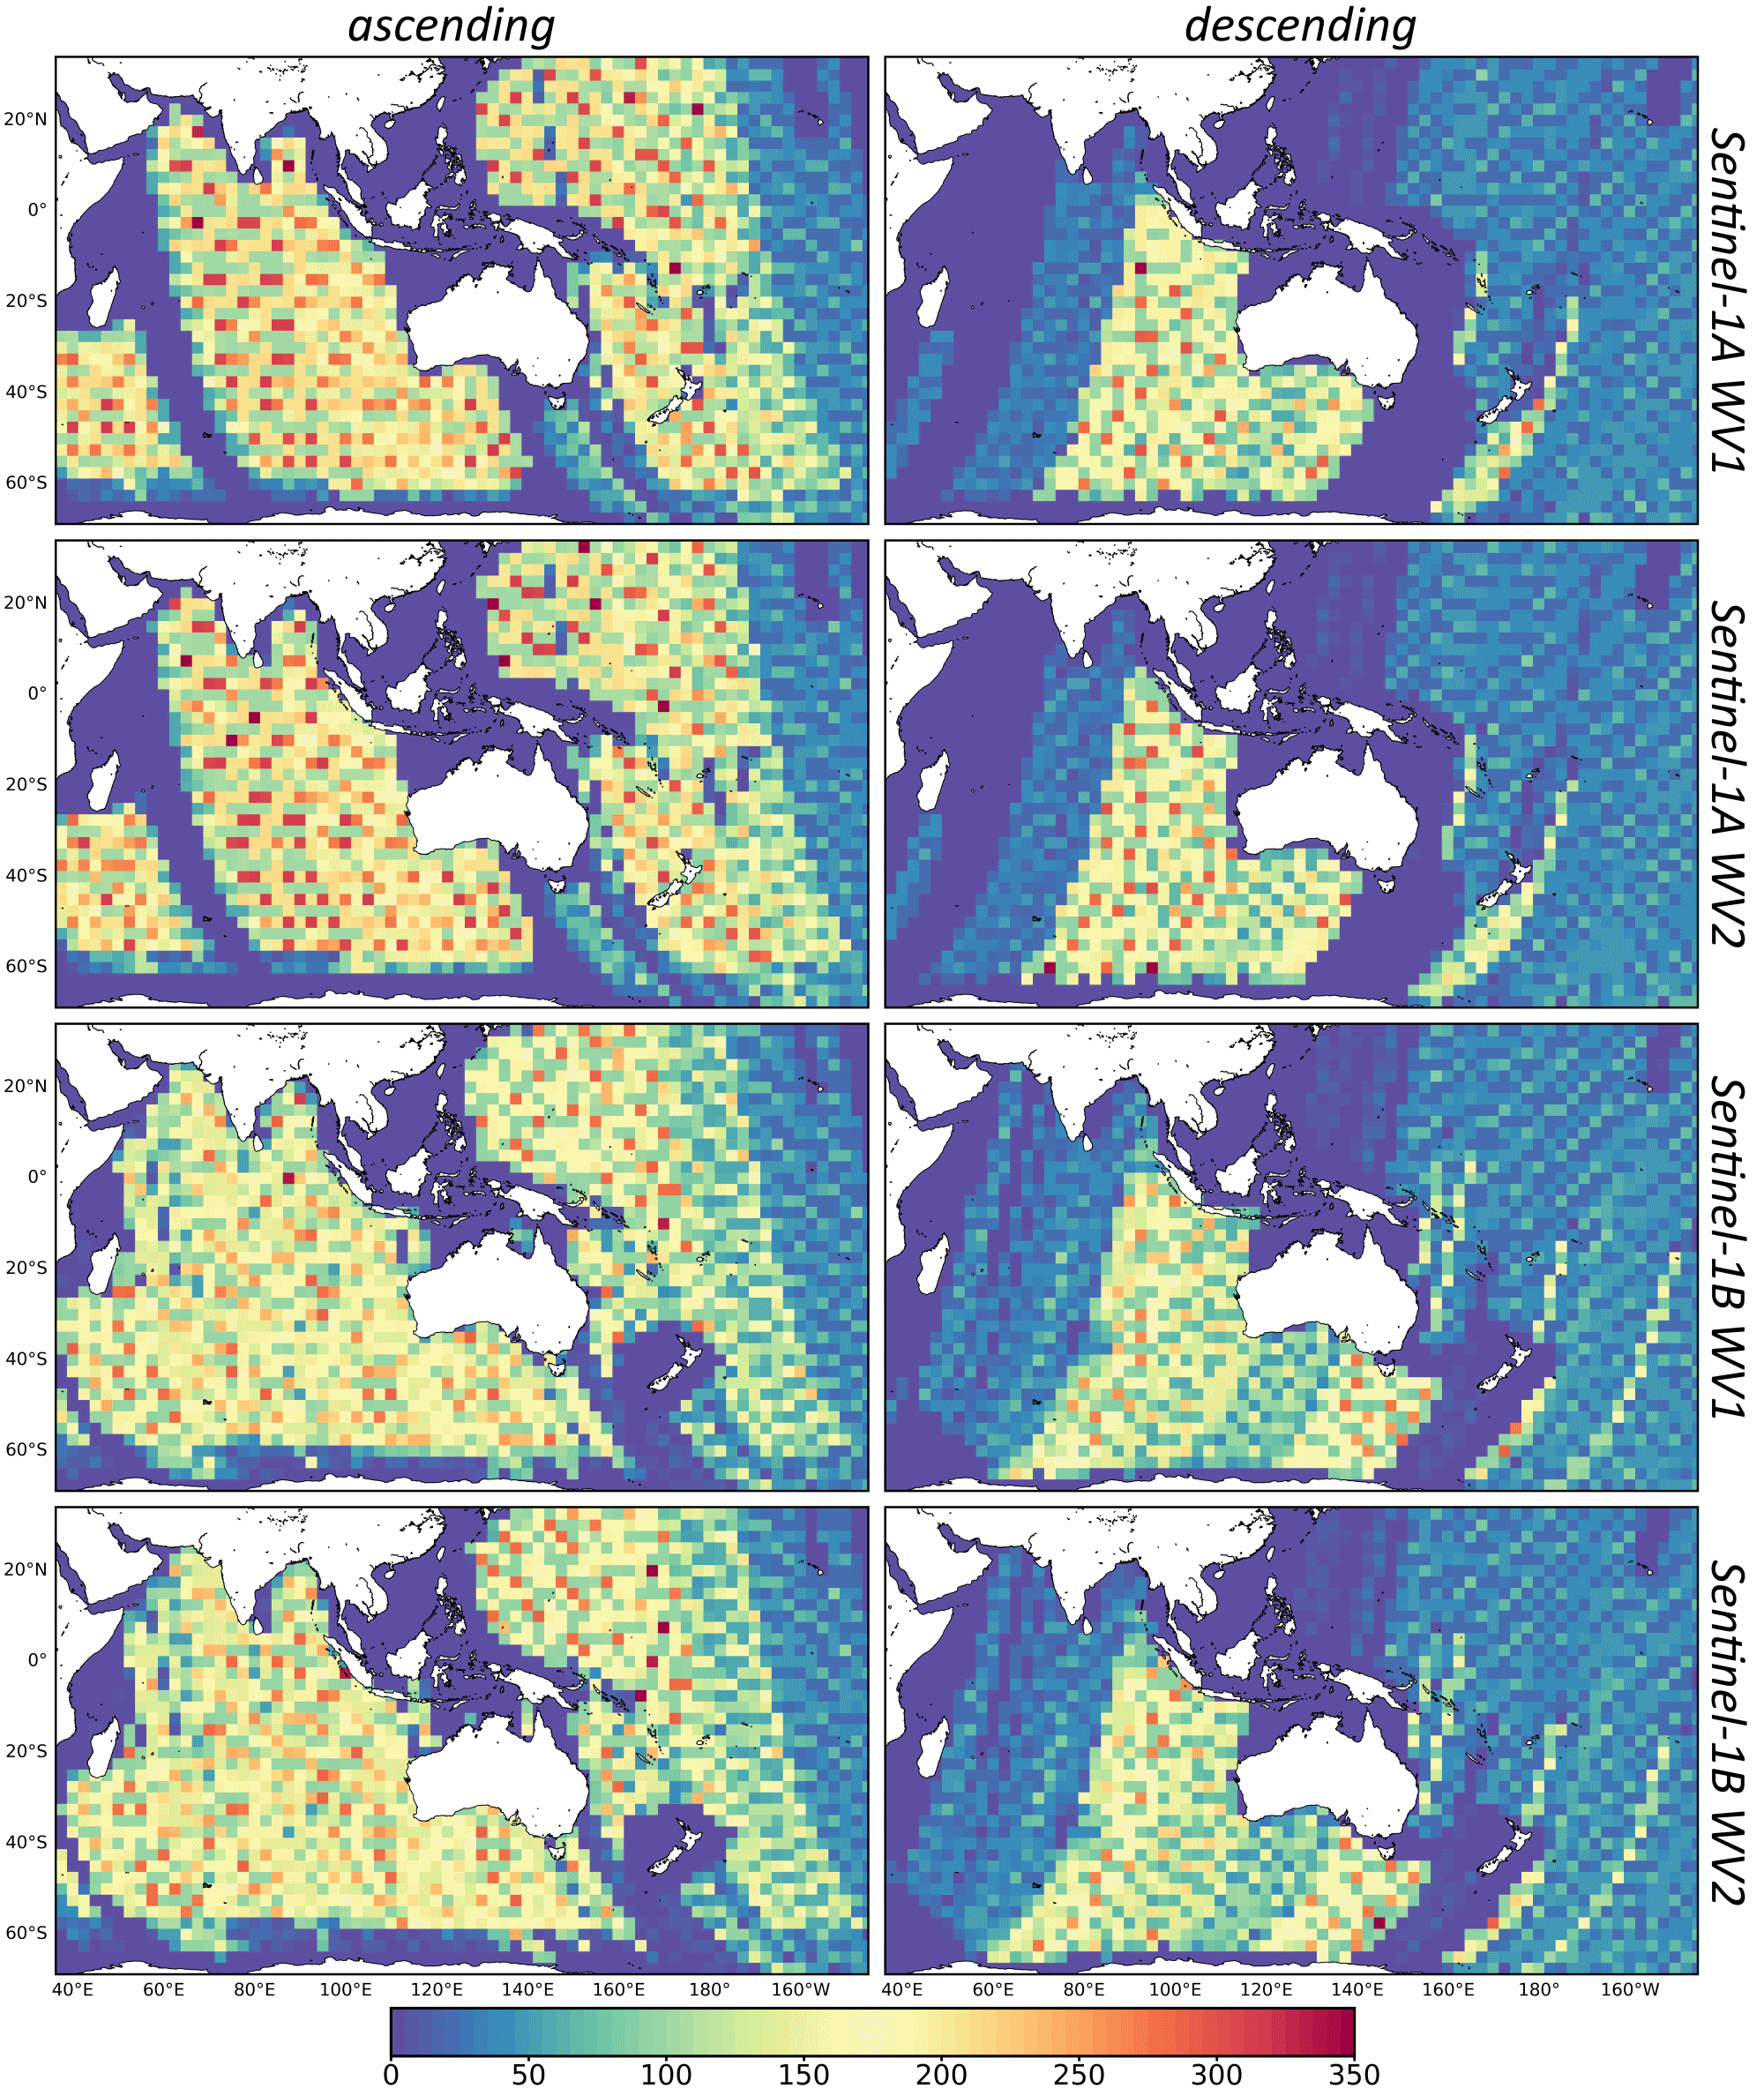

In [ ]:
import os
import sys
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from wavespectra import SpecArray
import xarray as xr

from utilfuncs import k2f, ek2f, s1_compute_efth, cmap_wavespectra, plot_part

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['mathtext.fontset'] = 'cm'

### Read a daily along-track netCDF file and visualise selected measurements off Albany, WA on a map

In [ ]:
# read and select measurements near South Australia
dset_s1 = xr.open_dataset('http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR/DELAYED/SENTINEL-1A/2019/08/IMOS_SRS-Surface-Waves_W_20190801T040752Z_Sentinel-1A_FV01_DM00_K2_END-20190801T220024Z.nc',
                        decode_times =  True, decode_cf = True, mask_and_scale =  True)
dset_WA = dset_s1.isel(TIME = slice(384, 404))

# plot measurement locations
fig = plt.figure(figsize = (10, 5), dpi = 100)
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 195))
ax.coastlines()
ax.plot(dset_s1.LONGITUDE, dset_s1.LATITUDE, '.', 
        transform = ccrs.PlateCarree(), markersize = 1)

ax.plot(dset_WA.LONGITUDE, dset_WA.LATITUDE,
        'r.', transform = ccrs.PlateCarree(), markersize = 2)
plt.show()

### Plot some auxialliary variables as the satellite measures along-track
- satellite heading
- incidence angle
- distance to coast, and 
- depth 

In [ ]:
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.HEADING.plot(ax = ax, lw=2, c='r')
plt.title('Heading') 
plt.grid(linestyle = 'dashed')

fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.INC_ANGLE.plot(ax = ax, lw=2, c='b')
plt.title('Incidence Angle') 
plt.grid(linestyle = 'dashed')

fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.DIST2COAST.plot(ax = ax, lw=2, c='k')
plt.title('Distance to coast')
plt.grid(linestyle = 'dashed')

fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA.BOT_DEPTH.plot(ax = ax, lw=2, c='g')
plt.title('Depth')
plt.grid(linestyle = 'dashed')

### Convert directional wavenumber spectra to frequency spectra using deep water assumptions:
efth - spectral variance density 
- units m2.s.deg-1

In [ ]:
# compute efth
dset_WA_ws = dset_WA.assign(efth = s1_compute_efth(dset_WA))

### Plot some wave statistics derived from directional frequency spectra:
- swell significant height
- mean period - Tm02
- mean wave direction

A directional wave spectrum describes how the wave energy (more specifically, the variance spectral density) is distributed over frequencies (or wavenumbers) and directions. For a detailed description of wave spectra, its uses and applications, and the transformations from wavenumber to frequency spectra, see: Holthuijsen, L. (2007). Waves in Oceanic and Coastal Waters. Cambridge: Cambridge University Press. https://doi.org/10.1017/CBO9780511618536

It is very common to describe the wave climate with integrated (also called bulk) wave parameters, instead of with a directional wave spectra. These parameters represent average conditions of the wave climate. 

In [ ]:
# plot stats
# hs
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.spec.hs(tail = True).plot(ax = ax)
plt.title('Swell significant wave height')
plt.grid(linestyle = 'dashed')

# tm02
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.spec.tm02().plot(ax = ax)
plt.title('Mean period - Tm02')
plt.grid(linestyle = 'dashed')

# dm
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.spec.dm().plot(ax = ax)
plt.ylabel('Mean wave to direction $(^\circ)$')
plt.title('Mean wave direction')
plt.grid(linestyle = 'dashed')
plt.show()

### Visualise directional frequency spectra:
- 1st directional spectra
- all directional spectra
- all omni-directional spectra

In [ ]:
# Plot 1st directional spectra
fig = plt.figure(figsize = (7.5,7.5))
cmap = cmap_wavespectra(n = 64)
qcs = (dset_WA_ws
       .isel(time = 0)
       .spec
       .plot
       (kind='contourf',cmap = cmap,
                 as_period = True, 
                 as_log10 = False, 
                 show_direction_label = True,
                 levels = cmap.N,
#                  figsize = (7.5, 7.5),
                 robuts = True))

angle_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', '','NW']
qcs.ax.set_rlabel_position(180 + 45)
qcs.ax.set_thetagrids(angles = range(0, 360, 45),
                      labels = angle_labels)
qcs.ax.set_title('Variance density [$m^2 s deg{-1}$]')
plt.show()

In [ ]:
## Plot all directional spectra
ncols = 4
fg = (dset_WA_ws
      .efth
      .spec
      .plot
      (kind='contourf', col = "time", col_wrap = ncols, cmap = cmap,
                as_period = True, as_log10 = False, 
                show_direction_label = True, levels = cmap.N,
                robuts = True, size = 3, aspect = 1))

for i, ax in enumerate(fg.axes.flat):
    ax.set_rlabel_position(180 + 45)
    ax.set_thetagrids(angles = range(0, 360, 45),
                      labels = angle_labels)
fg.set_titles(pad = 15)
fg.set_ylabels('Wave period [s]', labelpad = 20)
fg.set_xlabels('Wave to direction [$^\circ$]', labelpad = 0)
fg.cbar.set_label('Variance density [$m^2 s deg{-1}$]', labelpad = 10)

In [ ]:
# Plot all omni-directional spectra
ncols = 4
fg = dset_WA_ws.spec.oned().plot.line(col = 'time', col_wrap = ncols)
fg.set_axis_labels(y_var = 'var. spec. density ($m^2s/deg$)')
for i, ax in enumerate(fg.axes.flat):
    ax.grid(True)

## Visualise directional frequency spectra swell partitions:

+ partitions of first directional spectrum
+ partitions of all directional spectra

In [ ]:
# plot partitions for 1st 2d spectrum
fig = plot_part(dset_WA_ws.EKTH_PART.isel(TIME = 0))

In [ ]:
# plot partitions for all 2d spectra
fig = plot_part(dset_WA_ws.EKTH_PART)

### Plot some primary swell wave statistics:

In [ ]:
# plot primary swell stats
# swell height
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.HS_PART.isel(PARTITION = 0).plot()
plt.title('Primary swell significant height') 
plt.grid(linestyle = 'dashed')

# direction at spectral peak
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.DP_PART.isel(PARTITION = 0).plot()
plt.title('Primary swell peak direction') 
plt.grid(linestyle = 'dashed')

# wavelength at spectral peak
fig = plt.figure(figsize = (7.5, 3))
ax = plt.subplot(111)
dset_WA_ws.WP_PART.isel(PARTITION = 0).plot()
plt.title('Primary swell peak wavelength') 
plt.grid(linestyle = 'dashed')